In [5]:
import os
from tqdm import tqdm
from collections import Counter
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import umap
import torch
from torch.utils.data import TensorDataset, DataLoader
from transformers import AutoModel, AutoTokenizer
from utils import get_length_info, get_cls_embeddings, aggregate_embeddings, process_and_merge_embeddings

seed = 42
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
device

device(type='cuda')

# No Processing

Here we just tokenize and embedd, without touching the dataset at all.

## Training Set

In [3]:
li_train = []
matchid_to_filename = {}

for filename in os.listdir("data/train_tweets"):
    df_temp = pd.read_csv(f"data/train_tweets/{filename}")
    li_train.append(df_temp)
    unique_match_ids = df_temp['MatchID'].unique()
    for match_id in unique_match_ids:
        matchid_to_filename[match_id] = filename

df_train = pd.concat(li_train, ignore_index=True)

In [3]:
df_train

,ID,MatchID,PeriodID,EventType,Timestamp,Tweet
0,11_0,11,0,0,1404575400000,RT @2014WorIdCup: Argentina vs Belgium\n\nWho ...
1,11_0,11,0,0,1404575400000,@elijahman_ time to focus on Belgium winning t...
2,11_0,11,0,0,1404575400000,RT @FIFAWorldCup: GLOBAL STADIUM: #Joinin with...
3,11_0,11,0,0,1404575400000,RT @CatholicNewsSvc: #PopeFrancis. Uh-oh. Arge...
4,11_0,11,0,0,1404575400000,RT @soccerdotcom: If he scores vs #BEL we'll a...
...,...,...,...,...,...,...
5056045,18_129,18,129,0,1276876799000,RT @nytimes FIFA World Cup -- Final Score: U.S...
5056046,18_129,18,129,0,1276876799000,Ugh!!! should've been 3-2 USA! #worldcup
5056047,18_129,18,129,0,1276876799000,RT @jaclynkeough: Ha! RT @someecards I'd rathe...
5056048,18_129,18,129,0,1276876799000,RT @gustavaulia: So many surprises at worldcup...


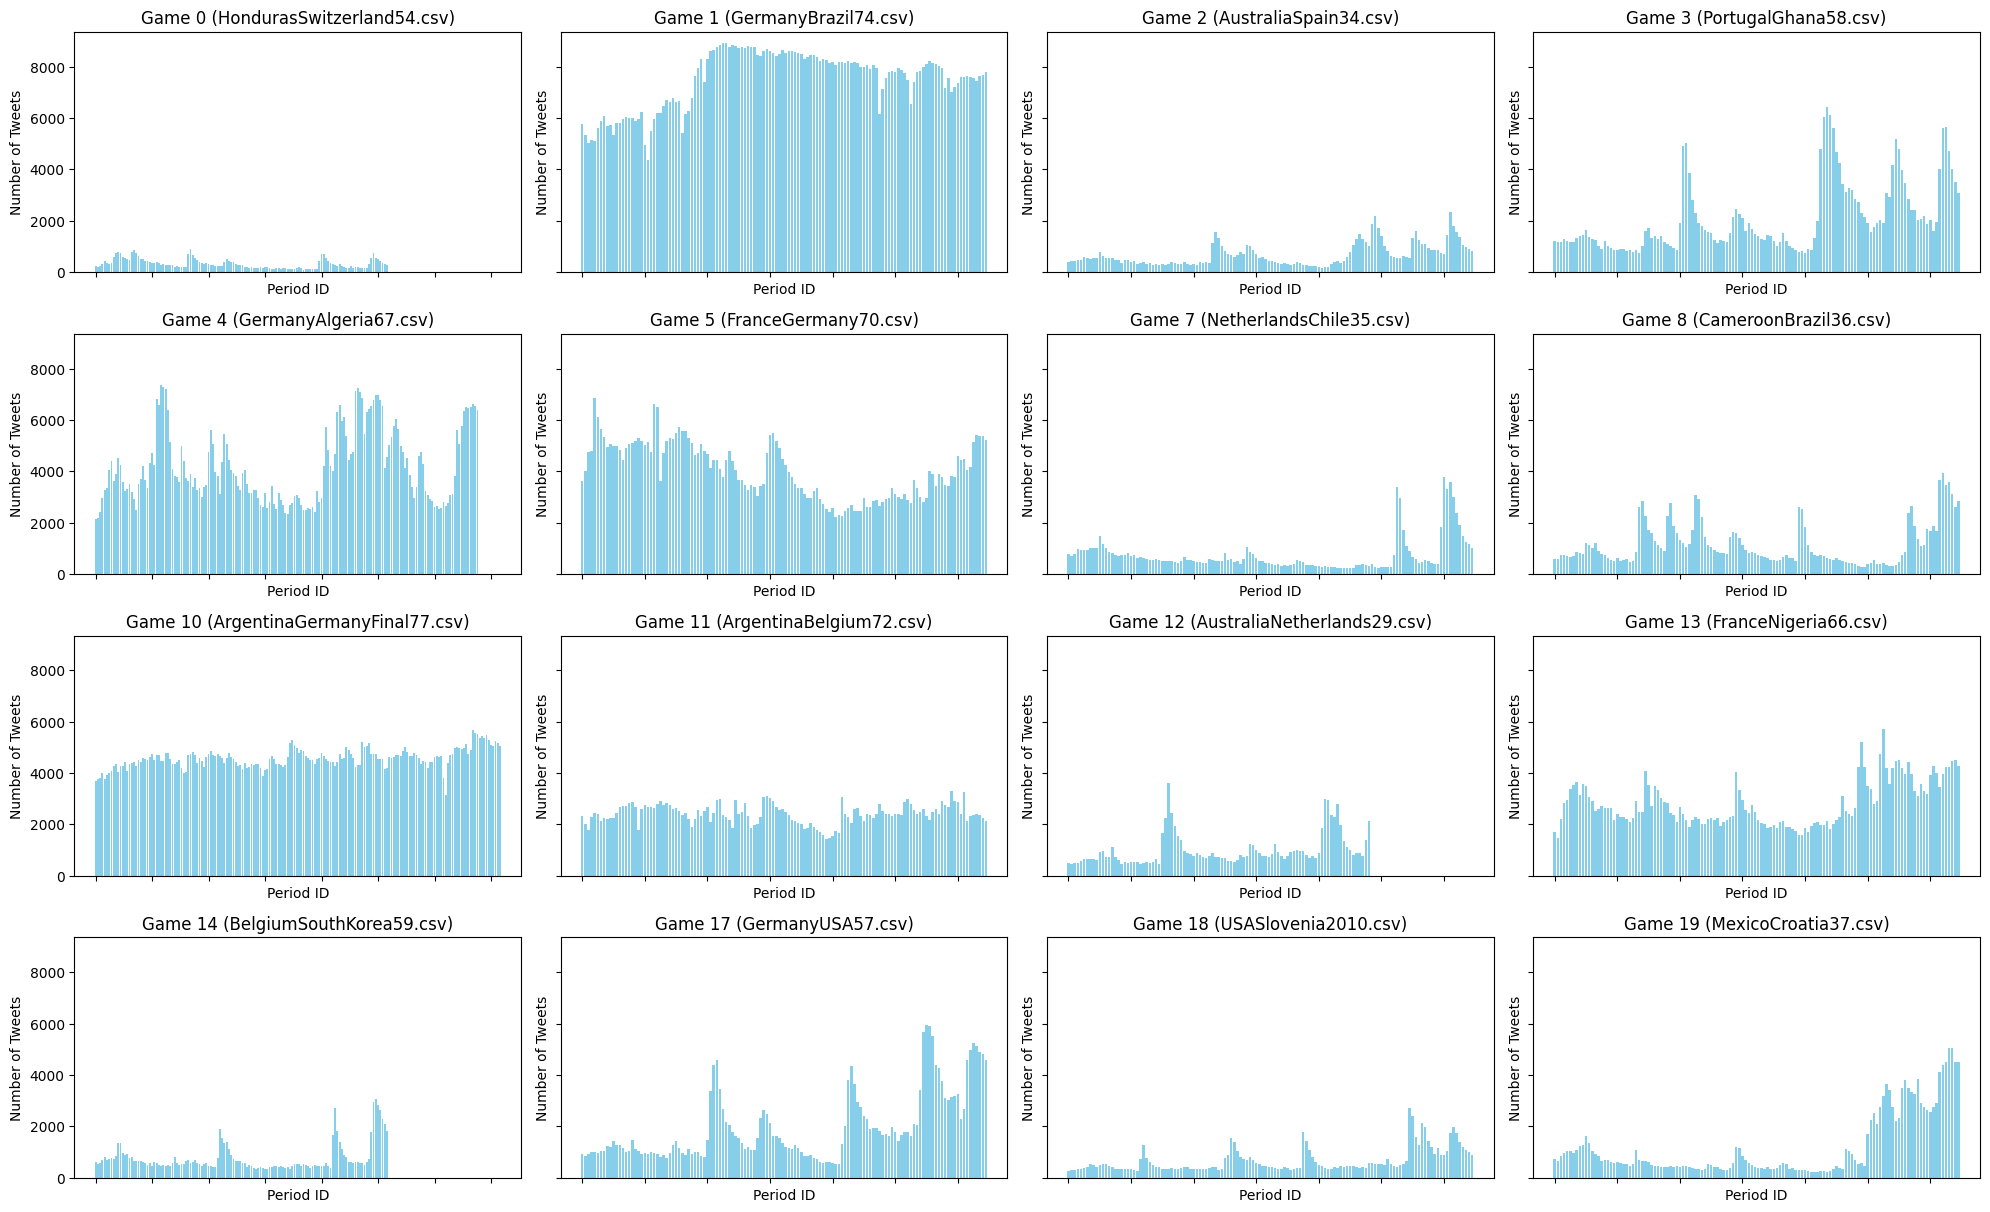

In [4]:
tweet_counts = df_train.groupby(['MatchID', 'PeriodID']).size().reset_index(name='TweetCount')
match_ids = tweet_counts['MatchID'].unique()
rows, cols = 4, 4

fig, axes = plt.subplots(rows, cols, figsize=(20, 15), sharex="col", sharey=True)
axes = axes.flatten()

for ax, match_id in zip(axes, match_ids):
    match_data = tweet_counts[tweet_counts['MatchID'] == match_id]
    file_name = matchid_to_filename.get(match_id, "Unknown")
    ax.bar(match_data['PeriodID'], match_data['TweetCount'], color='skyblue')
    ax.set_title(f'Game {match_id} ({file_name})')
    ax.set_xlabel('Period ID')
    ax.set_ylabel('Number of Tweets')

plt.tight_layout()
plt.show()

In [5]:
print(f"Total number of periods in the train set: {len(df_train['ID'].unique())}")
print(f"Max number of periods in a game in the train set: {len(df_train['PeriodID'].unique())}")

Total number of periods in the train set: 2137
Max number of periods in a game in the train set: 180


In [ ]:
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base")
model = AutoModel.from_pretrained("vinai/bertweet-base")
model = model.to(device)

Token Length Statistics:
  Max length: 257
  Average length: 27.06
  50th percentile length: 26.00
  75th percentile length: 37.00
  90th percentile length: 43.00
  95th percentile length: 47.00
  99th percentile length: 53.00


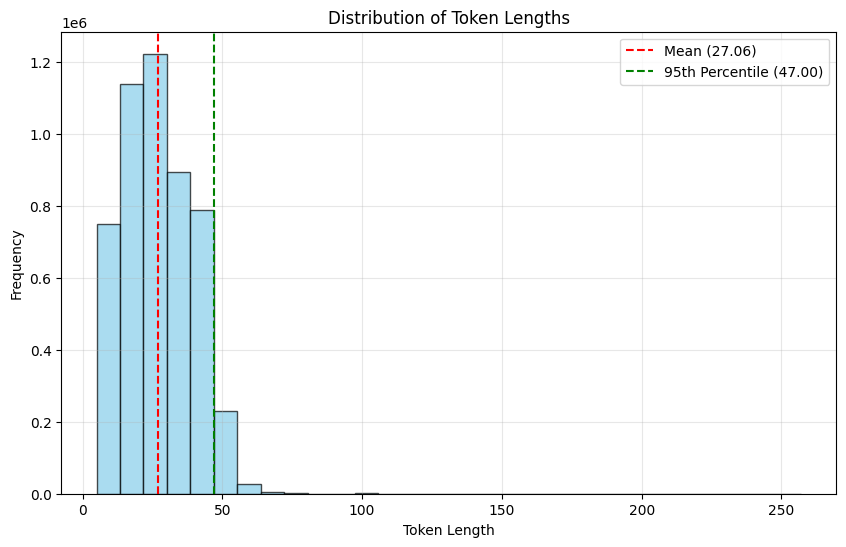

In [5]:
get_length_info(series=df_train["Tweet"], tokenizer=tokenizer, percentiles=[50, 75, 90, 95, 99], plot=True, verbose=True)

Let's choose 50 as our max length (checked also on test set below)

In [7]:
tokens = tokenizer(df_train["Tweet"].to_list(), max_length=50, padding="max_length", truncation=True, add_special_tokens=True, return_tensors="pt")

In [ ]:
torch.save((tokens['input_ids'], tokens['attention_mask']), "tokens/bertweet.pt")

In [3]:
# input_ids, attention_masks = torch.load("tokens/bertweet.pt")

C:\Users\sandr\AppData\Local\Temp\ipykernel_2288\671276624.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  input_ids, attention_masks = torch.load("tokens/bertweet.pt")


In [10]:
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

dataset = TensorDataset(tokens['input_ids'], tokens['attention_mask'])
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

In [11]:
final_cls_embeddings = get_cls_embeddings(model, dataloader, device)
assert final_cls_embeddings.shape == (df_train.shape[0], 768)

100%|██████████| 158002/158002 [4:57:54<00:00,  8.84it/s]  


Done!


In [12]:
df_train['cls'] = list(final_cls_embeddings.numpy())

In [ ]:
aggregated_embeddings, merged_df = process_and_merge_embeddings(
    df=df_train,
    cls_column='cls',
    id_column='ID',
    event_column='EventType',
    aggregation_func=aggregate_embeddings,
    criterion="mean",  
    output_format='pkl', 
    output_path="processed_data/aggregated_embeddings_with_labels.pkl"
)

Saving merged DataFrame as pkl in aggregated_embeddings_with_labels.pkl
Saved!


In [14]:
merged_df

,ID,aggregated_embedding,EventType
0,0_0,"[0.038894046, 0.2056955, 0.1732219, -0.0507800...",0
1,0_1,"[0.049072143, 0.20504853, 0.16913632, -0.04101...",0
2,0_10,"[-0.010199165, 0.19084008, 0.142129, -0.027013...",1
3,0_100,"[0.1076907, 0.18990463, 0.13662358, -0.0059914...",1
4,0_101,"[0.110753596, 0.21662608, 0.14855266, -0.02414...",1
...,...,...,...
2132,8_95,"[-0.12547426, 0.10333069, 0.012717849, 0.00890...",0
2133,8_96,"[-0.13536794, 0.08814793, 0.013134736, -0.0146...",1
2134,8_97,"[-0.13311367, 0.09247862, 0.016269028, 0.00072...",1
2135,8_98,"[-0.12481897, 0.07730664, 0.014376387, 0.00727...",0


The vectors are already normalized.

## Test Set

We repeat the same.

In [6]:
li_test = []
matchid_to_filename_test = {}

for filename in os.listdir("data/eval_tweets"):
    df_temp = pd.read_csv(f"data/eval_tweets/{filename}")
    li_test.append(df_temp)
    unique_match_ids_val = df_temp['MatchID'].unique()
    for match_id in unique_match_ids_val:
        matchid_to_filename_test[match_id] = filename

df_test = pd.concat(li_test, ignore_index=True)

In [37]:
df_test

,ID,MatchID,PeriodID,Timestamp,Tweet
0,6_0,6,0,1403376600000,I Finally get to see Germany play\n#GER 🇩🇪⚽🏆
1,6_0,6,0,1403376600000,RT @Wor1dCup2014: If Any of the Boateng Brothe...
2,6_0,6,0,1403376600000,Fascinated for this #GERvsGHA match. This will...
3,6_0,6,0,1403376600000,: #GER and #GHA in a few.
4,6_0,6,0,1403376600000,BOATENG GRUDGE MATCH: 21/2 for Jermaine to sco...
...,...,...,...,...,...
1072923,15_125,15,125,1404064800000,Dutch deserve to be in last 8.Keep their nerve...
1072924,15_125,15,125,1404064800000,RT @GeniusFootball: RETWEET if you think #MEX ...
1072925,15_125,15,125,1404064800000,"Hold your head high Mexico, played beautifully..."
1072926,15_125,15,125,1404064800000,RT @TheWorIdCup: Mexico fans right now... http...


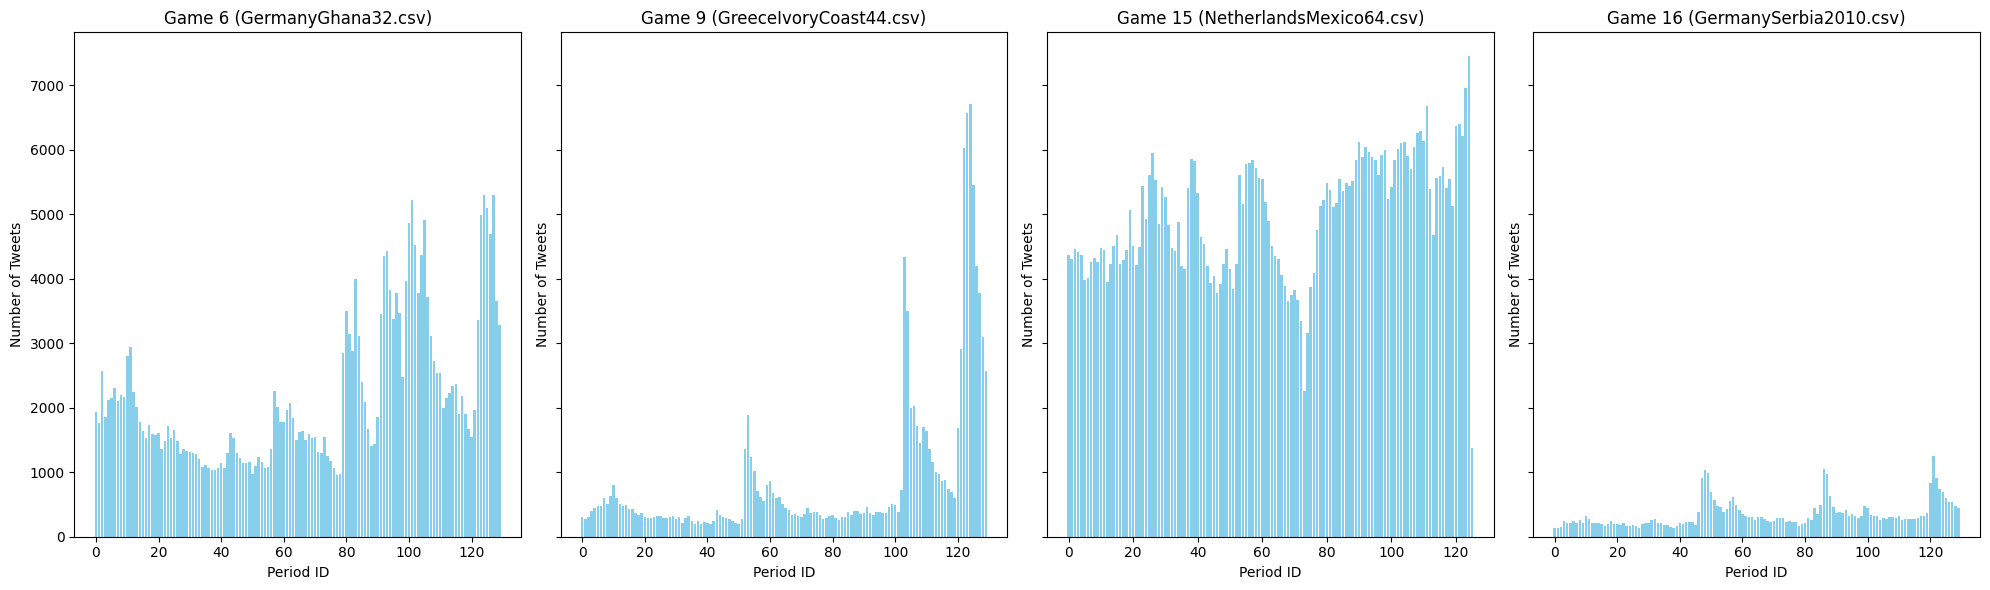

In [38]:
tweet_counts = df_test.groupby(['MatchID', 'PeriodID']).size().reset_index(name='TweetCount')
match_ids = tweet_counts['MatchID'].unique()
rows, cols = 1, 4

fig, axes = plt.subplots(rows, cols, figsize=(20, 6), sharex="col", sharey=True)
axes = axes.flatten()

for ax, match_id in zip(axes, match_ids):
    match_data = tweet_counts[tweet_counts['MatchID'] == match_id]
    file_name = matchid_to_filename_test.get(match_id, "Unknown")
    ax.bar(match_data['PeriodID'], match_data['TweetCount'], color='skyblue')
    ax.set_title(f'Game {match_id} ({file_name})')
    ax.set_xlabel('Period ID')
    ax.set_ylabel('Number of Tweets')

plt.tight_layout()
plt.show()

In [39]:
print(f"Total number of periods in the train set: {len(df_test['ID'].unique())}")
print(f"Max number of periods in a game in the train set: {len(df_test['PeriodID'].unique())}")

Total number of periods in the train set: 516
Max number of periods in a game in the train set: 130


In [7]:
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base")
model = AutoModel.from_pretrained("vinai/bertweet-base")
model = model.to(device)

Token Length Statistics:
  Max length: 257
  Average length: 26.93
  50th percentile length: 26.00
  75th percentile length: 36.00
  90th percentile length: 43.00
  95th percentile length: 46.00
  99th percentile length: 54.00


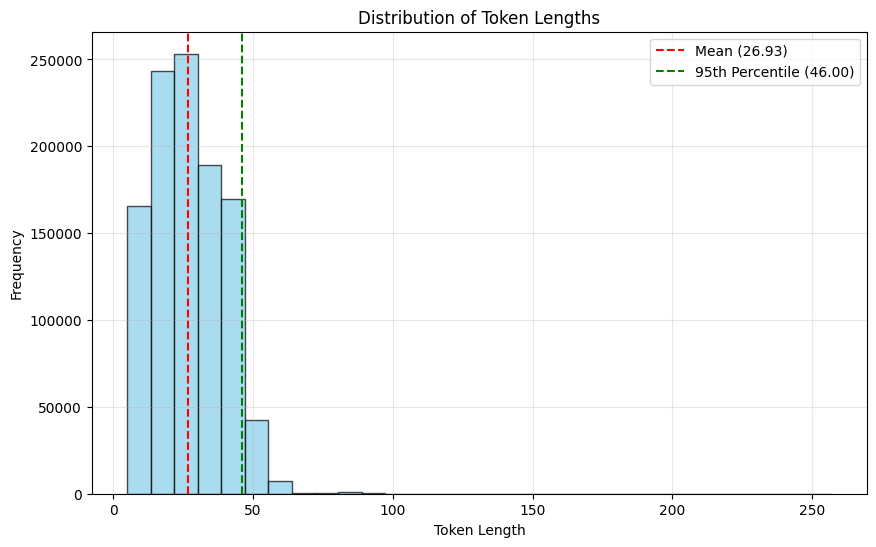

In [8]:
get_length_info(series=df_test["Tweet"], tokenizer=tokenizer, percentiles=[50, 75, 90, 95, 99], plot=True, verbose=True)

In [41]:
tokens_test = tokenizer(df_test["Tweet"].to_list(), max_length=50, padding="max_length", truncation=True, add_special_tokens=True, return_tensors="pt")

In [ ]:
torch.save((tokens_test['input_ids'], tokens_test['attention_mask']), "tokens/bertweet_test.pt")

In [ ]:
# input_ids_test, attention_masks_test = torch.load("tokens/bertweet_test.pt")

In [44]:
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

dataset_test = TensorDataset(tokens_test['input_ids'], tokens_test['attention_mask'])
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)

In [45]:
final_cls_embeddings_test = get_cls_embeddings(model, dataloader_test, device)
assert final_cls_embeddings_test.shape == (df_test.shape[0], 768)

100%|██████████| 33529/33529 [1:03:17<00:00,  8.83it/s]


Done!


In [46]:
df_test['cls'] = list(final_cls_embeddings_test.numpy())

In [48]:
df_test

,ID,MatchID,PeriodID,Timestamp,Tweet,cls
0,6_0,6,0,1403376600000,I Finally get to see Germany play\n#GER 🇩🇪⚽🏆,"[0.077867225, 0.09731847, 0.059819218, -0.1415..."
1,6_0,6,0,1403376600000,RT @Wor1dCup2014: If Any of the Boateng Brothe...,"[-0.063964926, 0.14290993, 0.0746815, -0.16638..."
2,6_0,6,0,1403376600000,Fascinated for this #GERvsGHA match. This will...,"[0.24081214, 0.13553065, 0.030091574, -0.20579..."
3,6_0,6,0,1403376600000,: #GER and #GHA in a few.,"[0.26232398, 0.018381672, -0.0555337, -0.11693..."
4,6_0,6,0,1403376600000,BOATENG GRUDGE MATCH: 21/2 for Jermaine to sco...,"[0.10413483, 0.13103765, 0.013799746, 0.014316..."
...,...,...,...,...,...,...
1072923,15_125,15,125,1404064800000,Dutch deserve to be in last 8.Keep their nerve...,"[0.06866108, 0.15437774, 0.2838874, -0.1459453..."
1072924,15_125,15,125,1404064800000,RT @GeniusFootball: RETWEET if you think #MEX ...,"[-0.025768155, 0.14188139, 0.12810758, -0.0807..."
1072925,15_125,15,125,1404064800000,"Hold your head high Mexico, played beautifully...","[-0.021281535, 0.27584612, 0.21054737, -0.0213..."
1072926,15_125,15,125,1404064800000,RT @TheWorIdCup: Mexico fans right now... http...,"[-0.16251707, 0.20360164, 0.09227639, -0.07586..."


In [ ]:
aggregated_embeddings_test, merged_df_test = process_and_merge_embeddings(
    df=df_test,
    cls_column='cls',
    id_column='ID',
    event_column="MatchID", # just put as a placeholder
    aggregation_func=aggregate_embeddings,
    criterion="mean",  
    output_format='pkl', 
    output_path="processed_data/aggregated_embeddings_with_labels_test.pkl"
)

Saving merged DataFrame as pkl in aggregated_embeddings_with_labels_test.pkl
Saved!


In [51]:
merged_df_test

,ID,aggregated_embedding,MatchID
0,15_0,"[-0.005626861, 0.17002444, 0.1560707, -0.07122...",15
1,15_1,"[-0.012398133, 0.16987626, 0.15416442, -0.0715...",15
2,15_10,"[-0.0063685165, 0.17705764, 0.14571677, -0.061...",15
3,15_100,"[-0.028167112, 0.21267831, 0.11889246, -0.0327...",15
4,15_101,"[-0.021408508, 0.20869574, 0.12005638, -0.0342...",15
...,...,...,...
511,9_95,"[-0.06389925, 0.15774356, 0.10894526, -0.06712...",9
512,9_96,"[-0.06254904, 0.16254315, 0.10645582, -0.07547...",9
513,9_97,"[-0.06544371, 0.15834767, 0.1077392, -0.078381...",9
514,9_98,"[-0.061433755, 0.15302086, 0.0968332, -0.06357...",9


## Data Visualization

Let's visualize our embeddings.

In [72]:
X = np.vstack(merged_df["aggregated_embedding"].values)
y = merged_df["EventType"].values

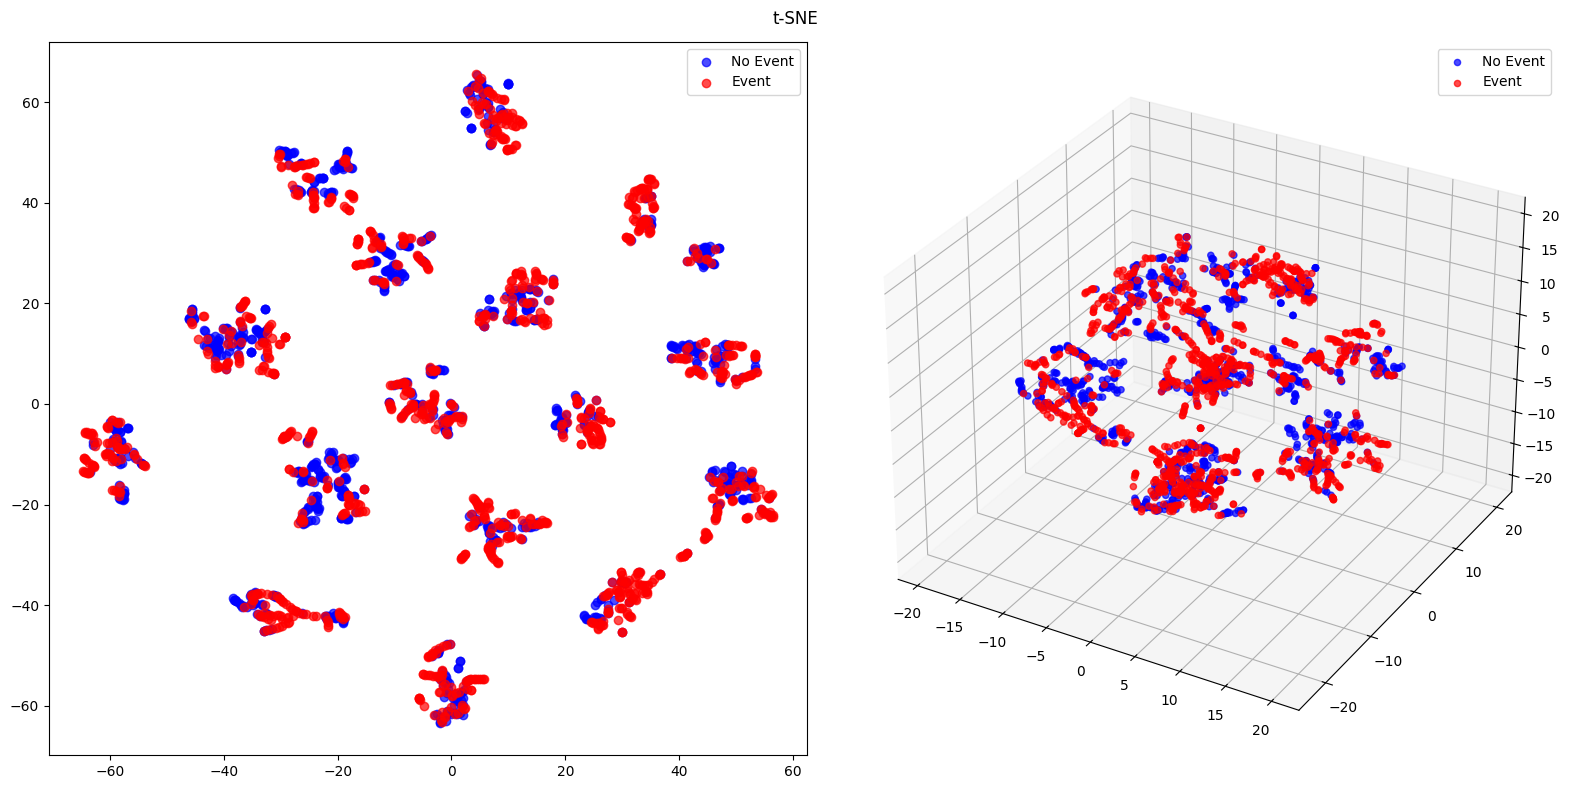

In [73]:
tsne2d = TSNE(n_components=2, random_state=seed)
reduced_embeddings2d = tsne2d.fit_transform(X)
tsne3d = TSNE(n_components=3, random_state=seed)
reduced_embeddings3d = tsne3d.fit_transform(X)

fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121)
for event_type, color, label in zip([0, 1], ['blue', 'red'], ['No Event', 'Event']):
    mask = (y == event_type)
    ax1.scatter(
        reduced_embeddings2d[mask, 0],
        reduced_embeddings2d[mask, 1],
        c=color,
        label=label,
        alpha=0.7
    )
ax1.legend()
ax2 = fig.add_subplot(122, projection='3d')
for event_type, color, label in zip([0, 1], ['blue', 'red'], ['No Event', 'Event']):
    mask = (y == event_type)
    ax2.scatter(
        reduced_embeddings3d[mask, 0],
        reduced_embeddings3d[mask, 1],
        reduced_embeddings3d[mask, 2],
        c=color,
        label=label,
        alpha=0.7
    )
ax2.legend()
plt.suptitle("t-SNE")
plt.tight_layout()
plt.show()

c:\Users\sandr\anaconda3\envs\mldl-ecole\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\sandr\anaconda3\envs\mldl-ecole\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


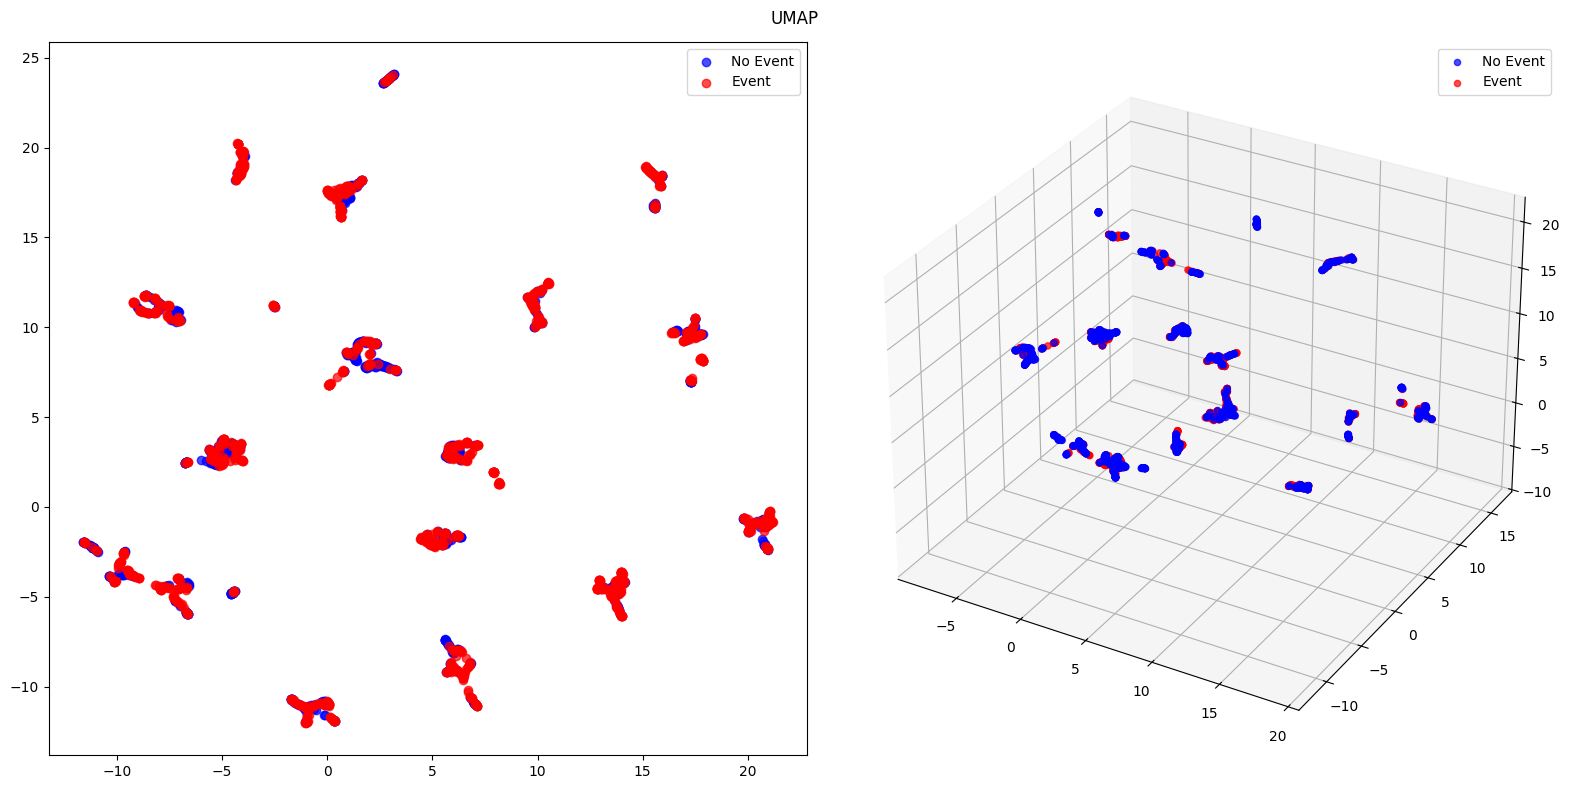

In [76]:
umap2d = umap.UMAP(n_components=2, random_state=seed)
reduced_embeddings2d = umap2d.fit_transform(X)
umap3d = umap.UMAP(n_components=3, random_state=seed)
reduced_embeddings3d = umap3d.fit_transform(X)

fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121)
for event_type, color, label in zip([0, 1], ['blue', 'red'], ['No Event', 'Event']):
    mask = (y == event_type)
    ax1.scatter(
        reduced_embeddings2d[mask, 0],
        reduced_embeddings2d[mask, 1],
        c=color,
        label=label,
        alpha=0.7
    )
ax1.legend()
ax2 = fig.add_subplot(122, projection='3d')
for event_type, color, label in zip([0, 1], ['blue', 'red'], ['No Event', 'Event']):
    mask = (y == event_type)
    ax2.scatter(
        reduced_embeddings3d[mask, 0],
        reduced_embeddings3d[mask, 1],
        reduced_embeddings3d[mask, 2],
        c=color,
        label=label,
        alpha=0.7
    )
ax2.legend()
plt.suptitle("UMAP")
plt.tight_layout()
plt.show()

Each game is clustered. The 2D and 3D plots are too low-dimensional to efficiently portray the separation between the positive and negative class. This is a suggestion for improving preprocessing to better distinguish the two classes, e.g. remove bad tweets (random, retweets), change embedding, constrative learning, feature engineering, etc.

# Preprocessing

Here we try to clean the data.

## Training Set

In [2]:
def find_teams(data, teams_dict):
    """
    Identifies the two most commonly mentioned teams in a DataFrame column containing tweets.

    Args:
        data (pd.DataFrame): The DataFrame containing the tweets.
        teams_dict (dict): A dictionary mapping team full names to their acronyms.

    Returns:
        tuple: A tuple containing the full names of the two most commonly mentioned teams.

    Raises:
        ValueError: If there are not enough teams mentioned in the dataset to identify two distinct teams.
    """
    team_counter = Counter()

    for tweet in data['Tweet']:
        for team_full, team_acronym in teams_dict.items():
            # Combine counts of full names and acronyms
            if re.search(rf"\b{team_full}\b", tweet, re.IGNORECASE) or re.search(rf"\b{team_acronym}\b", tweet, re.IGNORECASE):
                team_counter[team_full] += 1  # Count everything under the full name

    # Identify the two most common teams
    most_common_teams = team_counter.most_common(2)
    if len(most_common_teams) < 2:
        raise ValueError("Not enough teams found in the dataset to identify team_1 and team_2.")

    # Return the full names of the two teams
    team_1 = most_common_teams[0][0]
    team_2 = most_common_teams[1][0]

    return team_1, team_2

In [3]:
def replace_team_mentions(text, team_1, team_2, teams_dict):
    """
    Replaces mentions of specific teams in a text with generic tags for normalization.

    Args:
        text (str): The input text in which team mentions should be replaced.
        team_1 (str): The full name of the first team to normalize mentions as "<team_1>".
        team_2 (str): The full name of the second team to normalize mentions as "<team_2>".
        teams_dict (dict): A dictionary mapping team full names to their acronyms.

    Returns:
        str: The text with mentions of team_1 replaced by "<team_1>", mentions of team_2 replaced by "<team_2>", 
             and mentions of other teams replaced by "<team>".
    """
    # Replace mentions of team_1
    for alias in [team_1, teams_dict[team_1]]:
        text = re.sub(rf"\b{alias}\b", "<team_1>", text, flags=re.IGNORECASE)

    # Replace mentions of team_2
    for alias in [team_2, teams_dict[team_2]]:
        text = re.sub(rf"\b{alias}\b", "<team_2>", text, flags=re.IGNORECASE)

    # Replace mentions of all other teams
    for team_full, team_acronym in teams_dict.items():
        if team_full != team_1 and team_full != team_2:
            text = re.sub(rf"\b{team_full}\b", "<team>", text, flags=re.IGNORECASE)
            text = re.sub(rf"\b{team_acronym}\b", "<team>", text, flags=re.IGNORECASE)

    return text

In [4]:
def clean_tweets(df, column_name="Tweet", replace_teams=False, teams_dict = None, remove_one_word_tweets=False):
    """
    Cleans a DataFrame column containing tweets by performing various preprocessing steps.

    Args:
        df (pd.DataFrame): The DataFrame containing the tweets to clean.
        column_name (str, optional): The name of the column to clean. Defaults to "Tweet".
        replace_teams (bool, optional): Whether to replace team mentions with generic tags. Defaults to False.
        teams_dict (dict, optional): A dictionary mapping team names to their acronyms. Defaults to a predefined dictionary.
        remove_one_word_tweets (bool, optional): Whether to remove tweets with only one word. Defaults to False.

    Returns:
        pd.DataFrame: The DataFrame with the specified column cleaned.
    """
    # Emoji regex pattern
    EMOJI_PATTERN = re.compile(
        "[" 
        "\U0001F600-\U0001F64F"  # Emoticons
        "\U0001F300-\U0001F5FF"  # Symbols & Pictographs
        "\U0001F680-\U0001F6FF"  # Transport & Map Symbols
        "\U0001F1E0-\U0001F1FF"  # Flags
        "\U00002700-\U000027BF"  # Dingbats
        "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        "\U00002600-\U000026FF"  # Miscellaneous Symbols
        "\U00002B50-\U00002B55"  # Miscellaneous Symbols and Arrows
        "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        "]+",
        flags=re.UNICODE,
    )
    
    # We do this to make it adaptable to other datasets eventually
    if teams_dict is None:
        teams_dict = {
        "South Africa": "RSA", "Argentina": "ARG", "Australia": "AUS", "Brazil": "BRA",
        "Cameroon": "CMR", "Chile": "CHI", "Costa Rica": "CRC", "Denmark": "DEN",
        "England": "ENG", "France": "FRA", "Germany": "GER", "Ghana": "GHA",
        "Honduras": "HON", "Italy": "ITA", "Ivory Coast": "CIV", "Japan": "JPN",
        "Mexico": "MEX", "Netherlands": "NED", "New Zealand": "NZL", "Nigeria": "NGA",
        "North Korea": "PRK", "Paraguay": "PAR", "Portugal": "POR", "Slovakia": "SVK",
        "Slovenia": "SLO", "South Korea": "KOR", "Spain": "ESP", "Switzerland": "SUI",
        "United States": "USA", "Uruguay": "URU", "Algeria": "ALG", "Serbia": "SRB",
        "Belgium": "BEL", "Bosnia and Herzegovina": "BIH", "Colombia": "COL",
        "Croatia": "CRO", "Ecuador": "ECU", "Greece": "GRE", "Iran": "IRN",
        "Russia": "RUS"
        }

    df = df.drop_duplicates(subset=[column_name], keep="first") # Drop duplicates
    df = df[~df[column_name].str.startswith('RT')] # Remove retweets
    df.loc[:, column_name] = (
        df[column_name]
        .str.lower() # lowercase
        .apply(lambda text: re.sub(r'@\w+', '', text)) # Remove mentions
        .apply(lambda text: re.sub(r'#(\w+)', r'\1', text)) # Remove hashtag symbol
        .apply(lambda text: re.sub(r'http[s]?\S+', '', text)) # Remove URLs
        .apply(lambda text: re.sub(EMOJI_PATTERN, '', text)) # Remove emojis
        .apply(lambda text: text.replace('\n', '')) # Remove \n
        .apply(lambda text: re.sub(r'[^\w\s!?]', '', text)) # Remove punctuation except !,?
        .apply(lambda text: re.sub(r'\s+', ' ', text).strip()) # Remove extra spaces and trim
    )
    
    # Replace team mentions with generic tags
    if replace_teams:
        team_1, team_2 = find_teams(df, teams_dict)
        df.loc[:, column_name] = df[column_name].apply(lambda text: replace_team_mentions(text, team_1, team_2, teams_dict))

    df = df[df[column_name] != ''] # Remove rows with empty tweets
    df = df[df[column_name].apply(lambda text: bool(re.search(r'[a-zA-Z0-9]', text)))] # Remove rows with primarily non-ASCII characters
    
    # Keep tweets with more than one word
    if remove_one_word_tweets:
        df = df[df[column_name].apply(lambda text: len(text.split()) > 1)] 

    return df

In [6]:
li_train = []
matchid_to_filename = {}

for filename in tqdm(os.listdir("data/train_tweets"), desc="Processing Files"):
    df_temp = pd.read_csv(f"data/train_tweets/{filename}")
    df_temp = clean_tweets(df_temp, column_name="Tweet", replace_teams=True, remove_one_word_tweets=True)
    li_train.append(df_temp)
    unique_match_ids = df_temp['MatchID'].unique()
    for match_id in unique_match_ids:
        matchid_to_filename[match_id] = filename

df_train = pd.concat(li_train, ignore_index=True)

Processing Files: 100%|██████████| 16/16 [11:57<00:00, 44.87s/it] 


In [7]:
df_train

,ID,MatchID,PeriodID,EventType,Timestamp,Tweet
0,11_0,11,0,0,1404575400000,time to focus on <team_2> winning the world cup
1,11_0,11,0,0,1404575400000,i just hope <team_1> lose would be fun to see ...
2,11_0,11,0,0,1404575400000,watch <team_1> vs <team_2> 5th july 2014 live ...
3,11_0,11,0,0,1404575400000,why dont you like <team_1>
4,11_0,11,0,0,1404575400000,even though i hate <team_2> for beating the us...
...,...,...,...,...,...,...
2371329,18_129,18,129,0,1276876799000,ok so <team> has to tie and not score more tha...
2371330,18_129,18,129,0,1276876799000,but that was a real soccer match after so many...
2371331,18_129,18,129,0,1276876799000,no! <team_1> worldcup
2371332,18_129,18,129,0,1276876799000,woah that was an awesome game of soccer just p...


In [8]:
df_train["EventType"].value_counts(normalize=True)

EventType
1    0.573498
0    0.426502
Name: proportion, dtype: float64

In [9]:
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base")
model = AutoModel.from_pretrained("vinai/bertweet-base")
model = model.to(device)

Token Length Statistics:
  Max length: 159
  Average length: 20.59
  50th percentile length: 19.00
  75th percentile length: 26.00
  90th percentile length: 32.00
  95th percentile length: 35.00
  99th percentile length: 41.00


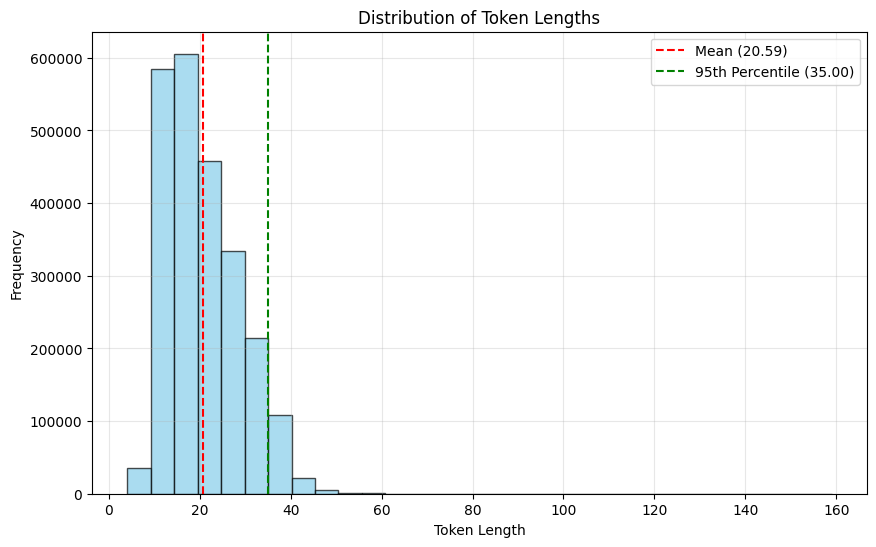

In [10]:
get_length_info(series=df_train["Tweet"], tokenizer=tokenizer, percentiles=[50, 75, 90, 95, 99], plot=True, verbose=True)

This allows us to consider even less tokens (so more computationally efficient). Let's choose 40 tokens.

In [11]:
tokens = tokenizer(df_train["Tweet"].to_list(), max_length=40, padding="max_length", truncation=True, add_special_tokens=True, return_tensors="pt")

In [12]:
torch.save((tokens['input_ids'], tokens['attention_mask']), "tokens/bertweet_processed_no_teams.pt")

In [ ]:
# input_ids, attention_masks = torch.load("tokens/bertweet_processed_no_teams.pt")

In [13]:
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

dataset = TensorDataset(tokens['input_ids'], tokens['attention_mask'])
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

In [14]:
final_cls_embeddings = get_cls_embeddings(model, dataloader, device)
assert final_cls_embeddings.shape == (df_train.shape[0], 768)

100%|██████████| 74105/74105 [1:53:05<00:00, 10.92it/s]  


Done!


In [15]:
df_train['cls'] = list(final_cls_embeddings.numpy())

In [16]:
aggregated_embeddings, merged_df = process_and_merge_embeddings(
    df=df_train,
    cls_column='cls',
    id_column='ID',
    event_column='EventType',
    aggregation_func=aggregate_embeddings,
    criterion="mean",  
    output_format='pkl', 
    output_path="processed_data/aggregated_processed_no_teams_embeddings_with_labels.pkl"
)

Saving merged DataFrame as pkl in processed_data/aggregated_processed_no_teams_embeddings_with_labels.pkl
Saved!


In [17]:
merged_df

,ID,aggregated_embedding,EventType
0,0_0,"[0.06464398, 0.24089995, 0.16664307, -0.074556...",0
1,0_1,"[0.071705356, 0.25698385, 0.16703025, -0.05735...",0
2,0_10,"[0.057482347, 0.24828523, 0.1672239, -0.058664...",1
3,0_100,"[0.07220905, 0.25018337, 0.15347967, -0.054650...",1
4,0_101,"[0.077298984, 0.2536793, 0.16394459, -0.059102...",1
...,...,...,...
2132,8_95,"[0.029660298, 0.236199, 0.13026236, -0.0455470...",0
2133,8_96,"[0.032921184, 0.23035926, 0.14154892, -0.06174...",1
2134,8_97,"[0.039330192, 0.2337406, 0.13621277, -0.055048...",1
2135,8_98,"[0.032339074, 0.24242172, 0.123065844, -0.0457...",0


## Test Set

In [19]:
li_test = []
matchid_to_filename_test = {}

for filename in os.listdir("data/eval_tweets"):
    df_temp = pd.read_csv(f"data/eval_tweets/{filename}")
    li_test.append(df_temp)
    unique_match_ids_val = df_temp['MatchID'].unique()
    for match_id in unique_match_ids_val:
        matchid_to_filename_test[match_id] = filename

df_test = pd.concat(li_test, ignore_index=True)

In [20]:
df_test

,ID,MatchID,PeriodID,Timestamp,Tweet
0,6_0,6,0,1403376600000,I Finally get to see Germany play\n#GER 🇩🇪⚽🏆
1,6_0,6,0,1403376600000,RT @Wor1dCup2014: If Any of the Boateng Brothe...
2,6_0,6,0,1403376600000,Fascinated for this #GERvsGHA match. This will...
3,6_0,6,0,1403376600000,: #GER and #GHA in a few.
4,6_0,6,0,1403376600000,BOATENG GRUDGE MATCH: 21/2 for Jermaine to sco...
...,...,...,...,...,...
1072923,15_125,15,125,1404064800000,Dutch deserve to be in last 8.Keep their nerve...
1072924,15_125,15,125,1404064800000,RT @GeniusFootball: RETWEET if you think #MEX ...
1072925,15_125,15,125,1404064800000,"Hold your head high Mexico, played beautifully..."
1072926,15_125,15,125,1404064800000,RT @TheWorIdCup: Mexico fans right now... http...


In [21]:
df_test[df_test.duplicated(subset=['Tweet'])].shape[0] / df_test.shape[0]

0.42031711354349965

In [22]:
df_test[df_test['Tweet'].str.startswith('RT')].shape[0] / df_test.shape[0]

0.4978908183960154

In [23]:
df_test = clean_tweets(df_test, column_name="Tweet")

In [24]:
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base")
model = AutoModel.from_pretrained("vinai/bertweet-base")
model = model.to(device)

Token Length Statistics:
  Max length: 147
  Average length: 13.41
  50th percentile length: 12.00
  75th percentile length: 17.00
  90th percentile length: 23.00
  95th percentile length: 26.00
  99th percentile length: 31.00


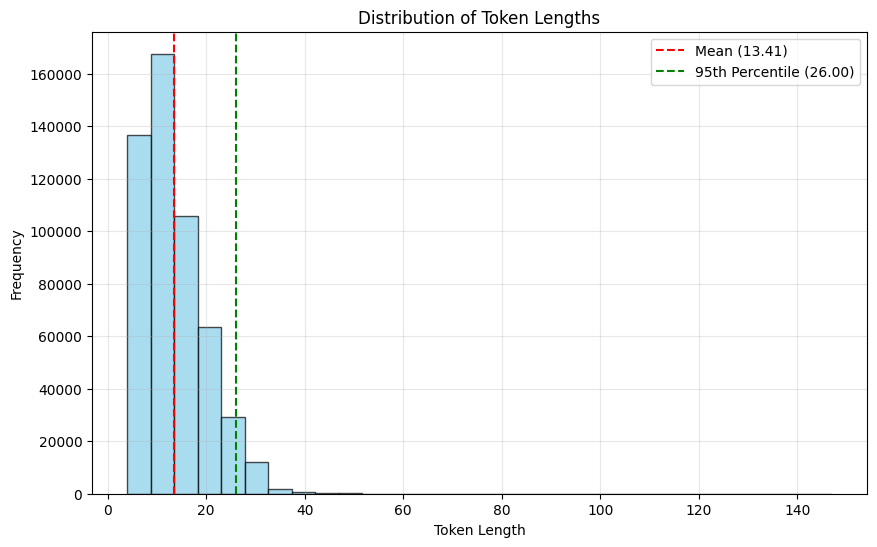

In [25]:
get_length_info(series=df_test["Tweet"], tokenizer=tokenizer, percentiles=[50, 75, 90, 95, 99], plot=True, verbose=True)

In [ ]:
tokens_test = tokenizer(df_test["Tweet"].to_list(), max_length=40, padding="max_length", truncation=True, add_special_tokens=True, return_tensors="pt")

In [ ]:
torch.save((tokens_test['input_ids'], tokens_test['attention_mask']), "tokens/bertweet_processed_no_teams_test.pt")

In [28]:
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

dataset_test = TensorDataset(tokens_test['input_ids'], tokens_test['attention_mask'])
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)

In [29]:
final_cls_embeddings_test = get_cls_embeddings(model, dataloader_test, device)
assert final_cls_embeddings_test.shape == (df_test.shape[0], 768)

100%|██████████| 16196/16196 [18:59<00:00, 14.21it/s]


Done!


In [30]:
df_test['cls'] = list(final_cls_embeddings_test.numpy())

In [31]:
df_test

,ID,MatchID,PeriodID,Timestamp,Tweet,cls
0,6_0,6,0,1403376600000,i finally get to see germany play,"[0.029694013, 0.20027314, 0.124139324, -0.0960..."
2,6_0,6,0,1403376600000,fascinated for this match this will tell us a ...,"[0.04934165, 0.22817752, 0.17347883, -0.129729..."
3,6_0,6,0,1403376600000,and in a few,"[0.08098821, 0.18531531, 0.01793776, -0.055570..."
4,6_0,6,0,1403376600000,boateng grudge match 212 for jermaine to score...,"[-0.051558286, 0.15814866, 0.053013876, -0.069..."
5,6_0,6,0,1403376600000,our players jooo,"[0.05737931, 0.3207237, 0.2694806, -0.07316735..."
...,...,...,...,...,...,...
1072920,15_125,15,125,1404064800000,what a team world cup goal keeper,"[-0.16882503, 0.22322458, 0.1526506, -0.087292..."
1072921,15_125,15,125,1404064800000,harsh on mexico though,"[-0.32816836, 0.16676416, 0.12622023, -0.13393..."
1072923,15_125,15,125,1404064800000,dutch deserve to be in last 8keep their nerve ...,"[0.0955326, 0.1898902, 0.27309263, -0.19467586..."
1072925,15_125,15,125,1404064800000,hold your head high mexico played beautifully ...,"[-0.1302141, 0.2067234, 0.16042322, -0.1560796..."


In [ ]:
aggregated_embeddings_test, merged_df_test = process_and_merge_embeddings(
    df=df_test,
    cls_column='cls',
    id_column='ID',
    event_column="MatchID", # just put as a placeholder
    aggregation_func=aggregate_embeddings,
    criterion="mean",  
    output_format='pkl', 
    output_path="processed_data/aggregated_processed_no_teams_embeddings_with_labels_test.pkl"
)

Saving merged DataFrame as pkl in processed_data/aggregated_processed_embeddings_with_labels_test.pkl
Saved!


In [33]:
merged_df_test

,ID,aggregated_embedding,MatchID
0,15_0,"[-0.042813946, 0.1918769, 0.17898202, -0.11207...",15
1,15_1,"[-0.038495164, 0.19319385, 0.1793268, -0.10927...",15
2,15_10,"[-0.036898967, 0.19677816, 0.17107427, -0.1048...",15
3,15_100,"[-0.03365067, 0.20892584, 0.15872918, -0.09230...",15
4,15_101,"[-0.042539142, 0.20417327, 0.16477127, -0.0975...",15
...,...,...,...
511,9_95,"[-0.037434276, 0.16205093, 0.14952455, -0.1119...",9
512,9_96,"[-0.027837986, 0.17199956, 0.15286605, -0.1113...",9
513,9_97,"[-0.03261823, 0.16872731, 0.15467678, -0.11286...",9
514,9_98,"[-0.029838722, 0.16490075, 0.15284179, -0.1054...",9


## Data Visualization

In [18]:
file_path = "processed_data/aggregated_processed_no_teams_embeddings_with_labels.pkl"
merged_df = pd.read_pickle(file_path)
X = np.vstack(merged_df["aggregated_embedding"].values)
y = merged_df["EventType"].values

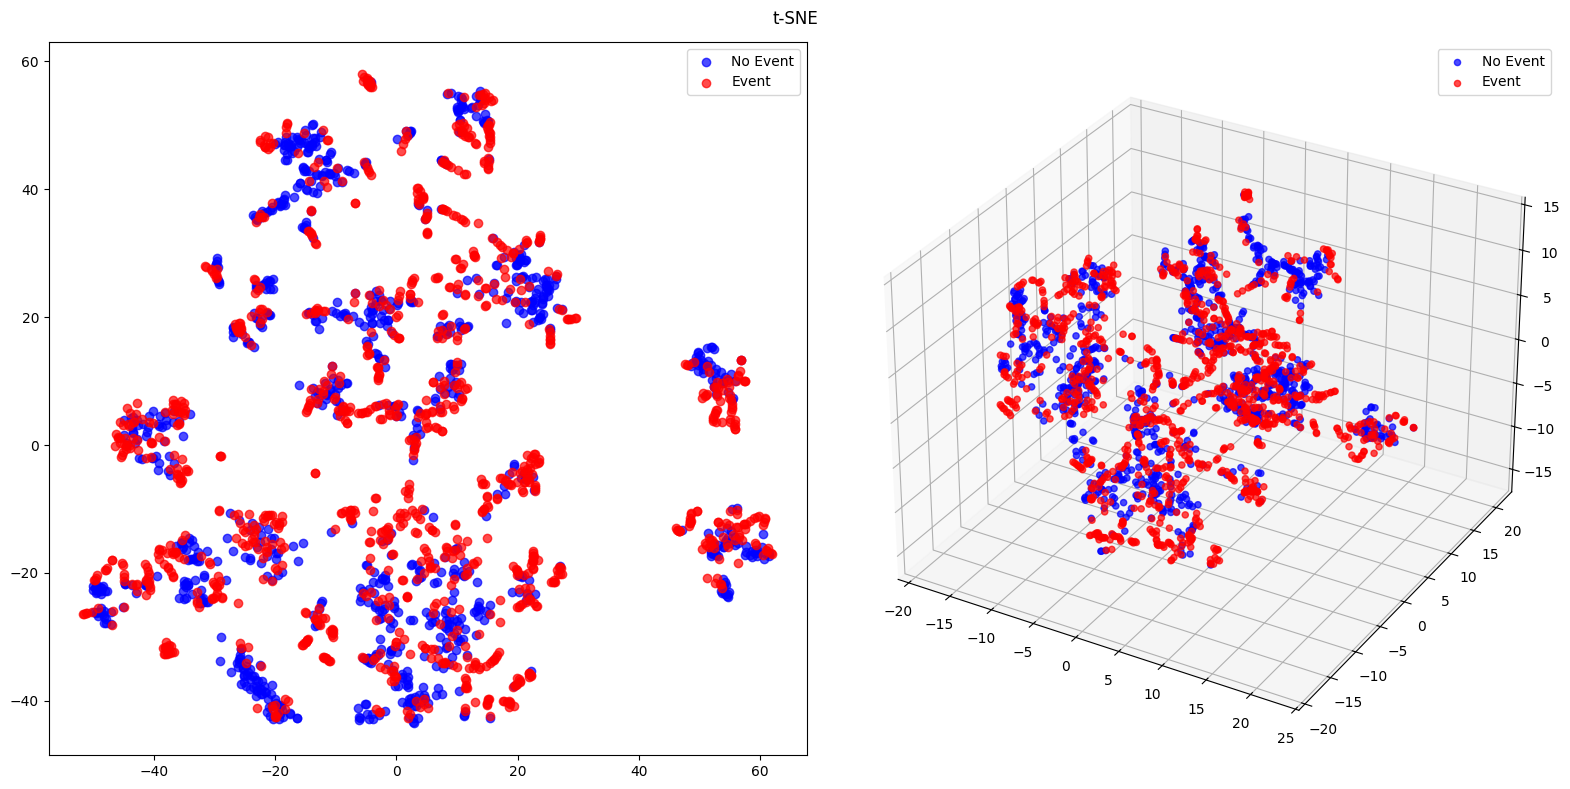

In [19]:
tsne2d = TSNE(n_components=2, random_state=seed)
reduced_embeddings2d = tsne2d.fit_transform(X)
tsne3d = TSNE(n_components=3, random_state=seed)
reduced_embeddings3d = tsne3d.fit_transform(X)

fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121)
for event_type, color, label in zip([0, 1], ['blue', 'red'], ['No Event', 'Event']):
    mask = (y == event_type)
    ax1.scatter(
        reduced_embeddings2d[mask, 0],
        reduced_embeddings2d[mask, 1],
        c=color,
        label=label,
        alpha=0.7
    )
ax1.legend()
ax2 = fig.add_subplot(122, projection='3d')
for event_type, color, label in zip([0, 1], ['blue', 'red'], ['No Event', 'Event']):
    mask = (y == event_type)
    ax2.scatter(
        reduced_embeddings3d[mask, 0],
        reduced_embeddings3d[mask, 1],
        reduced_embeddings3d[mask, 2],
        c=color,
        label=label,
        alpha=0.7
    )
ax2.legend()
plt.suptitle("t-SNE")
plt.tight_layout()
plt.show()

c:\Users\sandr\anaconda3\envs\mldl-ecole\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\sandr\anaconda3\envs\mldl-ecole\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


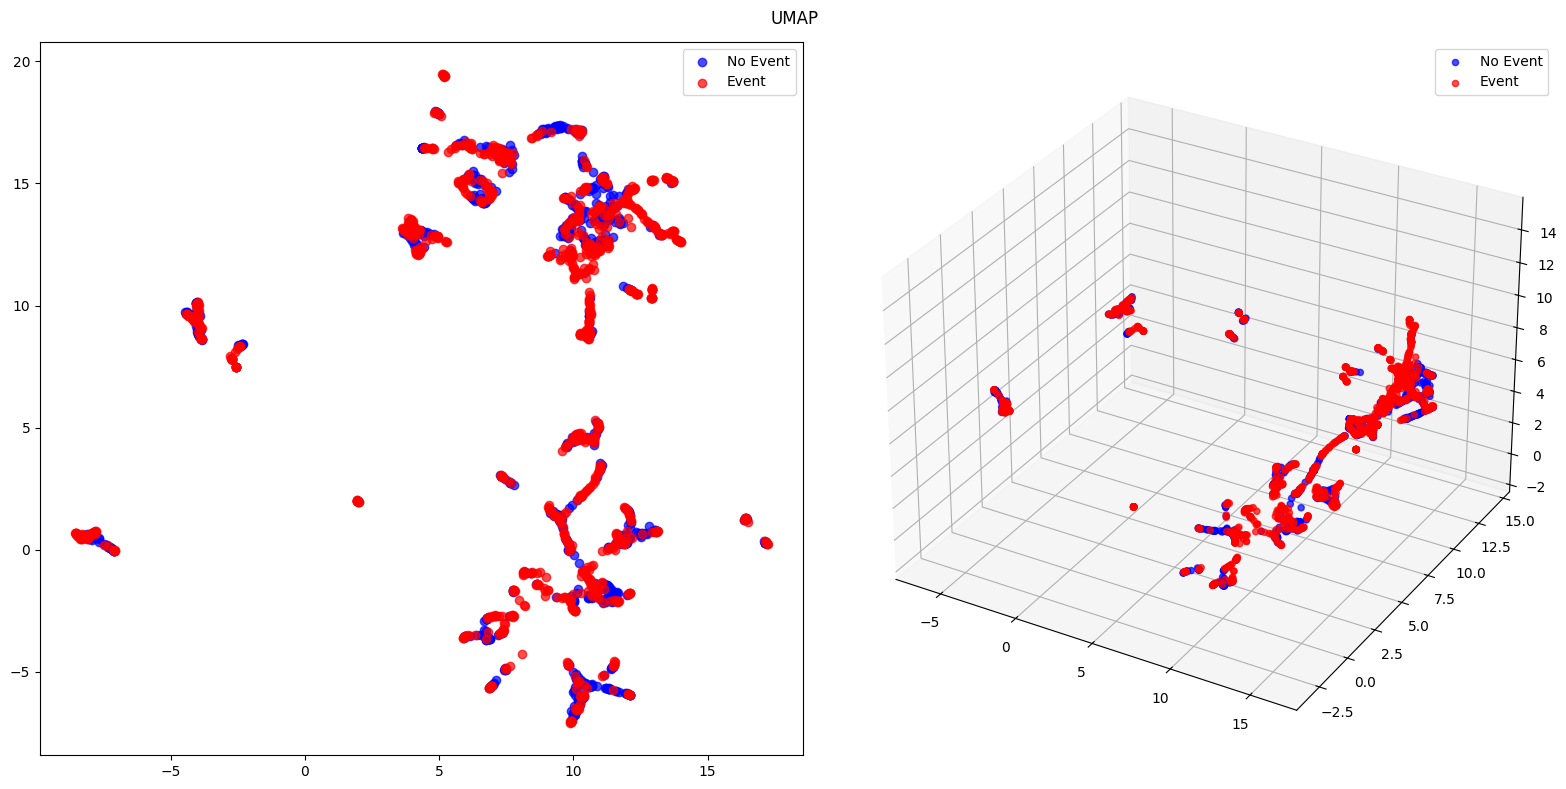

In [20]:
umap2d = umap.UMAP(n_components=2, random_state=seed)
reduced_embeddings2d = umap2d.fit_transform(X)
umap3d = umap.UMAP(n_components=3, random_state=seed)
reduced_embeddings3d = umap3d.fit_transform(X)

fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121)
for event_type, color, label in zip([0, 1], ['blue', 'red'], ['No Event', 'Event']):
    mask = (y == event_type)
    ax1.scatter(
        reduced_embeddings2d[mask, 0],
        reduced_embeddings2d[mask, 1],
        c=color,
        label=label,
        alpha=0.7
    )
ax1.legend()
ax2 = fig.add_subplot(122, projection='3d')
for event_type, color, label in zip([0, 1], ['blue', 'red'], ['No Event', 'Event']):
    mask = (y == event_type)
    ax2.scatter(
        reduced_embeddings3d[mask, 0],
        reduced_embeddings3d[mask, 1],
        reduced_embeddings3d[mask, 2],
        c=color,
        label=label,
        alpha=0.7
    )
ax2.legend()
plt.suptitle("UMAP")
plt.tight_layout()
plt.show()

Now it seems like the event and non-event periods are a bit more separable.